# DESARROLLO DE MODELOS PREDICTIVOS PARA LA CLASIFICACIÓN DE RIESGOS CREDITICIOS

En este notebook se presentarán las implementaciones de los 4 modelos predictivos propuestos en el paper "":
- Logistic Regression
- Random Forest
- K-Nearest Neighbors

## ESTRUCTURA
Este trabajo se estructurará de acuerdo a las fases descritas en el framework CRISP DM:
1. Comprensión del negocio
2. Comprensión de los datos
3. Preparación de los datos
4. Modelado
5. Evaluación
6. ~~Despliegue (ausente)~~


## 1. COMPRENSIÓN DEL NEGOCIO

En los servicios financieros, específicamente en la atención a una solicitud de crédito para un fin específico, es necesaria la evaluación del solicitante para determinar si este podrá cancelar las cuotas o deudas que conlleva el crédito. Para ello, las entidades financieras se basan en 5 factores: Carácter, Capacidad, Capital, Colateral, Condiciones.

Estos cinco factores indican la estabilidad laboral del solicitante por medio de antecedentes, si posee solvencia económica para pagar el préstamo (proporción entre deudas e ingresos), la diferencia entre sus valores activos y pasivos, los activos que pueden ser expropiados si no cumple con el pago, y las circunstancias externas que puedan afectar la situación financiera del solicitante. Cabe aclarar que estos 5 factores son básicos para una evaluación, por lo que las entidades pueden aumentar y modificar factores para una evaluación más exhaustiva.

En este caso, solo se cuenta con data de 9 atributos de los solicitantes, por lo que no se podrá suplir las 5 Cs detalladas en su totalidad, pero sí se podrá observar cuáles de estos 9 atributos son los que influyen más en la decisión de clasificar a un solicitante como Riesgo Bueno o Riesgo Malo, y relacionarlos con los 5 factores descritos.

### OBJETIVOS

El objetivo de este trabajo es el de implementar 4 modelos predictivos de clasificación, evaluarlos con métricas para clasificación y comparar los resultados para determinar cuáles de estos cuatro puede ser utilizado como predictor en la evaluación de riesgos crediticios.

Además, se identificarán cuáles han sido los atributos más influyentes y confirmar que estos se basan en los 5 factores detallados.

## 2. COMPRENSIÓN DE LOS DATOS

### 2.1. RECOPILACIÓN

El conjunto de datos German Credit Risk original posee 1000 entradas con 20 atributos preparados por el Prof. Hoffmann (German Credit Risk UCI Machine Learning), pero de acuerdo con el conjunto de datos brindado para la realización de este informe se ha seleccionado 9 de estos 20 atributos los cuales son los que más influyen en la decisión de brindar un crédito.


### 2.2. COMPOSICIÓN

Se procede a analizar la data en base a sus atributos y a las 1000 observaciones:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv( 'data/german_credit_data.csv', index_col=0)
data.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

In [3]:
#Número de filas y columnas
data.shape

(1000, 10)

#### DATOS NULOS PRESENTES EN LA DATA
Si se analizan los tipos de datos de los atributos, observamos que 6 de 9 son de tipo `object`, los cuales son propensos a presentar datos nulos, por lo que se analizarán si se ha representado correctamente o no a un dato nulo dentro de las observaciones.

In [4]:
#Tipo de datos en la tabla
data.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

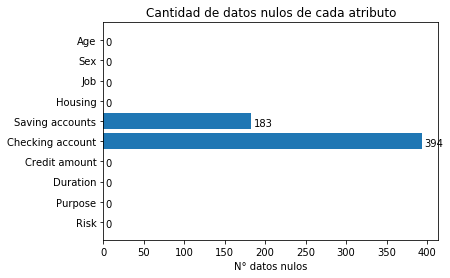

In [234]:
#Cantidad de datos nulos en las columnas

fig, ax = plt.subplots()
x_null, y_null = data.columns, data.isna().sum()

ax.barh(x_null, y_null)
ax.set_title("Cantidad de datos nulos de cada atributo")
ax.invert_yaxis()
ax.set_xlabel("N° datos nulos")
for i, v in enumerate(y_null):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='regular')

plt.savefig("imgs/datos_nulos.png")
plt.show()

Como se intuía, las clases que presentan mayor cantidad de datos nulos son `Saving accounts` y `Checking account`. Se presentan entonces todas las clases de los atributos que son de tipo `object`:

In [6]:
# información única en las columnas de datos discretos
for col in data.select_dtypes(include="object"):
    print(f"{col:16}: ", end=""), print(*(data[col].unique()), sep=", ")

Sex             : male, female
Housing         : own, free, rent
Saving accounts : nan, little, quite rich, rich, moderate
Checking account: little, moderate, nan, rich
Purpose         : radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others
Risk            : good, bad


#### ATRIBUTO JOB COMO TIPO ENTERO

Analizamos entonces toda la data entera, y se puede apreciar que el atributo `Job`, a pesar de no ser de tipo `object`, presenta 4 valores únicos. Esto se debe a que cada número describe al solicitante de la siguiente manera:
- 0 - unskilled and non-resident
- 1 - unskilled and resident
- 2 - skilled
- 3 - highly skilled

In [7]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

#### BALANCE DE CLASES EN TARGET

Según la gráfica, el 70% de los datos corresponden a la categoría de Riesgo Bueno. El desbalance entre las dos clases del target es evidente, pero no en extremo. Sin embargo, se optará por realizar las métricas de precisión y *recall*, además de una representación gráfica como la curva ROC, para todos los modelos de clasificación que se implementen y observar quién modela mejor los datos.

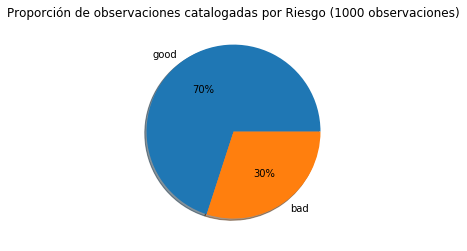

In [8]:
fig, ax = plt.subplots()
ax.pie(data['Risk'].value_counts(), autopct="%.0f%%", labels=data["Risk"].unique(), shadow=True)
ax.set_title("Proporción de observaciones catalogadas por Riesgo (1000 observaciones)")
plt.show()

### 2.3. CONCLUSIONES DE LA DATA OBSERVADA

1. En los atributos disponibles, se encuentra `Sex`, al cual no se le considerará como un atributo necesario
2. El atributo `Job` se está representando como `int`, pero se le considerará como **categórico**
3. Los tipos de los atributos son los siguientes:
    - __binarios__: Sex, Risk
    - __nominal__: Saving accounts, Checking account, Housing, Job, Purpose
    - __cardinal__: Age, Credit amount, Duration
4. De acuerdo al tipo del atributo, se normalizarán y modificarán para un mejor procesamiento al momento de entrenar a los modelos
4. Se han encontrado datos nulos en los atributos `Saving accounts` y `Checking account`, siendo este último el que presenta alrededor de 40% de data faltante, por lo que se considera aplicar métricas además del _accuracy_.

## 3. PREPARACIÓN DE LOS DATOS


### 3.1. Eliminación de atributo Sex
Se eliminará el atributo `Sex` con el fin de evitar de que el modelo de clasificación considere el sexo de un solicitante para asignarle un Riesgo Bueno o Riegos Malo.

In [9]:
clean_data = data.drop(labels="Sex", axis=1, inplace=False)
clean_data.head()

Age  Job Housing Saving accounts Checking account  Credit amount  Duration  \
0   67    2     own             NaN           little           1169         6   
1   22    2     own          little         moderate           5951        48   
2   49    1     own          little              NaN           2096        12   
3   45    2    free          little           little           7882        42   
4   53    2    free          little           little           4870        24   

               Purpose  Risk  
0             radio/TV  good  
1             radio/TV   bad  
2            education  good  
3  furniture/equipment  good  
4                  car   bad

### 3.2. Llenado de datos nulos
Los atributos `Saving accounts` y `Checking account` presentan datos nulos en sus registros, por lo que se utilizará la moda de cada una para poder llenarlas ya que son de tipo categórico.

In [10]:
print("Moda de Saving accounts : ", clean_data["Saving accounts"].mode()[0])
print("Moda de Checking account: ", clean_data["Checking account"].mode()[0])

Moda de Saving accounts :  little
Moda de Checking account:  little


In [11]:
clean_data['Saving accounts'].fillna(data['Saving accounts'].mode()[0], inplace=True)
clean_data['Checking account'].fillna(data['Checking account'].mode()[0], inplace=True)

In [12]:
clean_data.isna().sum()

Age                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

### 3.3. Transformación de datos cualitativos a cuantitativos

Una vez tenemos los datos sin valores faltantes, procedemos a representarlos numéricamente para que los modelos a implementar puedan utilizarlos como inputs para sus algoritmos. En este caso, se convertirán los siguientes atributos:
- ~~Sex~~ (ha sido eliminada)
- Housing
- Saving accounts
- Checking account
- Purpose
- Risk

In [13]:
from sklearn.preprocessing import LabelEncoder 

def encode_features(pre_data):
    features = ['Housing','Saving accounts','Checking account','Purpose', 'Risk']

    for feature in features:
        le = LabelEncoder()
        le = le.fit(pre_data[feature])
        pre_data[feature] = le.transform(pre_data[feature])

    return pre_data
    
clean_data = encode_features(clean_data)
clean_data.head()

Age  Job  Housing  Saving accounts  Checking account  Credit amount  \
0   67    2        1                0                 0           1169   
1   22    2        1                0                 1           5951   
2   49    1        1                0                 0           2096   
3   45    2        0                0                 0           7882   
4   53    2        0                0                 0           4870   

   Duration  Purpose  Risk  
0         6        5     1  
1        48        5     0  
2        12        3     1  
3        42        4     1  
4        24        1     0

Ahora se tiene a todos como datos numéricos, de los cuales `Age`, `Credit amount` y `Duration` no son categóricos, pero que en los modelos se trabajarán con intervalos.

In [14]:
clean_data.dtypes

Age                 int64
Job                 int64
Housing             int32
Saving accounts     int32
Checking account    int32
Credit amount       int64
Duration            int64
Purpose             int32
Risk                int32
dtype: object

## 4. MODELADO
Los modelos propuestos para la clasificación son los siguientes:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors

Para el entrenamiento, se utilizará parte de la data:

In [15]:
from sklearn.model_selection import train_test_split


X = clean_data.drop('Risk',axis=1).values
y = clean_data['Risk'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

print(f'Train shape     : {X_train.shape}')
print(f'Validation shape: {X_test.shape}')

Train shape     : (700, 8)
Validation shape: (300, 8)


### 4.1. LOGISTIC REGRESSION

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=7, solver="liblinear")
logreg.fit(X_train, y_train)

logreg_score_train = logreg.score(X_train, y_train)
logreg_score_test  = logreg.score(X_test, y_test)

print(f"Logistic Regression train SCORE: {logreg_score_train}")
print(f"Logistic Regression test  SCORE: {logreg_score_test}")

Logistic Regression train SCORE: 0.71
Logistic Regression test  SCORE: 0.7066666666666667


### 4.2. RANDOM FOREST

Ahora se implementará **_Random Forest_** con el coeficiente _**Gini**_ como medida de desigualdad. Los valores de los demás parámetros, como `max_depth` y `n_estimators`, han sido elegidos arbitrariamente por el momento.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='gini',max_depth=10, n_estimators=50, n_jobs=-1, random_state=7)
rfc.fit(X_train, y_train)

rfc_score_train = rfc.score(X_train, y_train)
rfc_score_test  = rfc.score(X_test, y_test)

print(f"Random Forest Classifier train SCORE: {rfc_score_train}")
print(f"Random Forest Classifier test  SCORE: {rfc_score_test}")

Random Forest Classifier train SCORE: 0.9371428571428572
Random Forest Classifier test  SCORE: 0.7033333333333334


Ahora se desea demostrar que los valores elegidos para los argumentos `max_depth` y `n_estimators` han sido los correctos para el RandomForest. Para ello, se variarán tanto la profundidad y el número de estimadores, e identificar en qué puntos aproximadamente el modelo presenta __overfitting__.

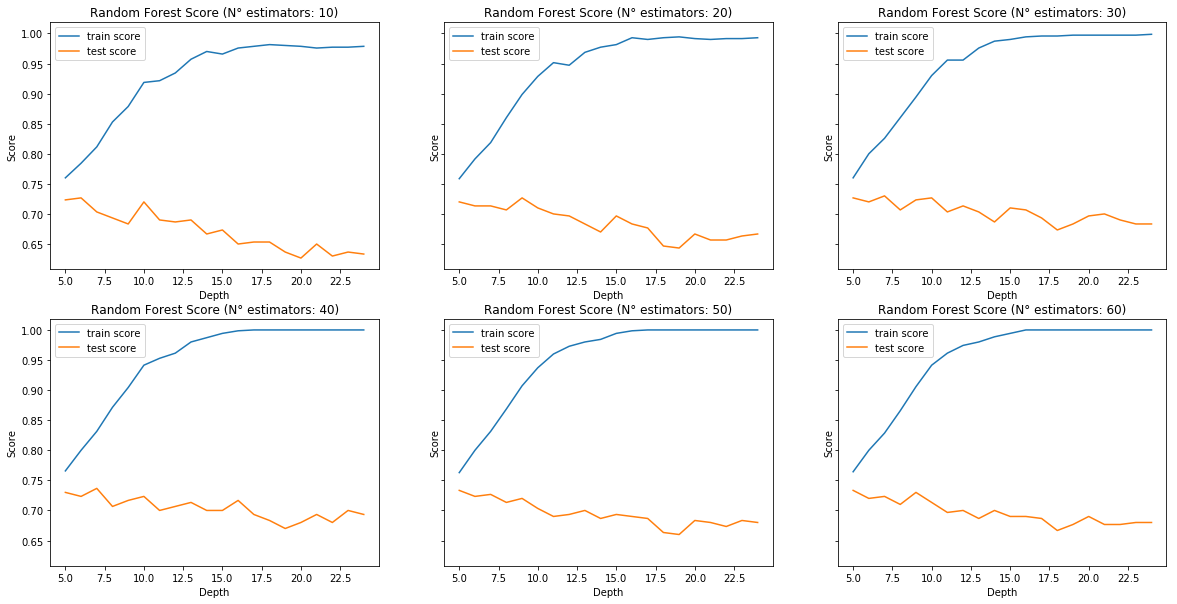

In [21]:
from itertools import product

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(20,10))

for (row, col), n_estimators in zip(product([*range(nrows)],[*range(ncols)]), [*range(10, 70, 10)]):
    rfc_reuse_score_train_list = []
    rfc_reuse_score_test_list = []
    
    for depth in range(5, 25):
        rfc_reuse = RandomForestClassifier(criterion='gini',max_depth=depth, n_estimators=n_estimators, n_jobs=-1, random_state=7)
        rfc_reuse.fit(X_train, y_train)
        
        rfc_reuse_score_train_list.append(rfc_reuse.score(X_train, y_train))
        rfc_reuse_score_test_list.append(rfc_reuse.score(X_test, y_test))

    axes[row, col].plot(range(5, 25), rfc_reuse_score_train_list,label="train score")
    axes[row, col].plot(range(5, 25), rfc_reuse_score_test_list, label="test score")
    axes[row, col].set_title(f"Random Forest Score (N° estimators: {n_estimators})")
    axes[row, col].set_xlabel("Depth")
    axes[row, col].set_ylabel("Score")
    axes[row, col].legend()

plt.savefig("imgs/random_forest_scores.png")
plt.show()

Dado el gráfico, se puede apreciar que el score de la data de entrenamiento se aproxima a 1 a partir de una profundidad de 15, por lo que se escogerá la misma configuración inicial, es decir, `max_depth=10` y `n_estimators=50`.

Sin embargo, como en el modelo anterior, no es suficiente evaluar al modelo con el _score_ obtenido.

### 4.3. K-NEAREST NEIGHBORS

Para la implementación de __*KNN*__, se usará la distancia de Minkowski en lugar de la Euclidiana. El número de vecinos a tomar en cuenta para la clasificación será colocado de manera arbitraria por el momento.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=17, p=3)
knn.fit(X_train, y_train)

knn_score_train = knn.score(X_train, y_train)
knn_score_test  = knn.score(X_test, y_test)

print(f"K-Nearest Neighbors train SCORE: {knn_score_train}")
print(f"K-Nearest Neighbors test  SCORE: {knn_score_test}")

K-Nearest Neighbors train SCORE: 0.7085714285714285
K-Nearest Neighbors test  SCORE: 0.71


Ahora se variará el número de vecinos para el __*KNN*__ e identificar en qué número empieza a presentar _overfitting_.

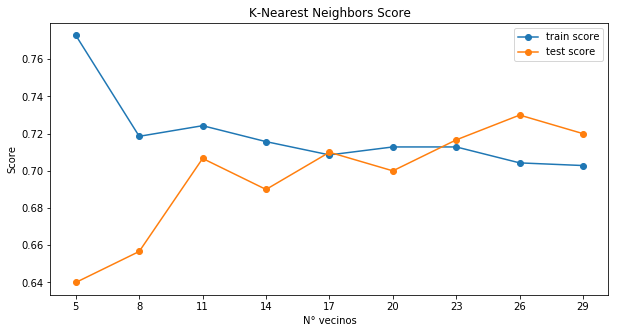

In [26]:
fig, ax = plt.subplots(figsize=(10,5))

knn_reuse_score_train_list = []
knn_reuse_score_test_list = []

for n_neighbors in range(5, 30, 3):
    knn_reuse = KNeighborsClassifier(n_neighbors=n_neighbors, p=3, n_jobs=-1)
    knn_reuse.fit(X_train, y_train)

    knn_reuse_score_train_list.append(knn_reuse.score(X_train, y_train))
    knn_reuse_score_test_list.append(knn_reuse.score(X_test, y_test))

ax.plot(range(5, 30, 3), knn_reuse_score_train_list,label="train score", marker='o')
ax.plot(range(5, 30, 3), knn_reuse_score_test_list, label="test score", marker='o')
ax.set_xticks(range(5, 30, 3))
ax.set_title(f"K-Nearest Neighbors Score")
ax.set_xlabel("N° vecinos")
ax.set_ylabel("Score")
ax.legend()

plt.savefig("imgs/knn_scores.png")
plt.show()

De acuerdo al gráfico, el __KNN__ modela modela de igual manera a la data de entrenamiento como a la de test con un score alrededor de `0.71`, por lo que se elegirá el número de vecinos a `17`.

Una vez más, de acuerdo al desbalance de clases en el target, es necesario realizar una evaluación más exhaustiva no solo con el _score_.

## 5. EVALUACIÓN

De acuerdo a los modelos entrenados, se compararán los _scores_ que presentan:

In [35]:
from sklearn.metrics import accuracy_score

models = {'LogisticRegression':logreg, 'RandomForestClassifier':rfc, 'KNeighborsClassifier':knn}
scores = {k:accuracy_score(y_test, model.predict(X_test)) for k, model in models.items()}

for model, score in scores.items():
    print(f"{model:25}: {score}")

LogisticRegression       : 0.7066666666666667
RandomForestClassifier   : 0.7033333333333334
KNeighborsClassifier     : 0.71


Se puede apreciar que, aunque los valores se encuentren separados en orden de centécimas, `KNeighborsClassifier` posee un mayor _accuracy_. Sin embargo, solo se ha probado con una representación de la data completa en la de entrenamiento y de test, es decir, solo una partición. Además, no se puede realizar una correcta comparación si no tomamos en cuenta el desbalance que se presenta en el _target_ de nuestra data.

Para estos problemas, se usarán las siguientes métricas para nuestros modelos de clasificación:
- Cross Validation (K-folds)
- Matriz de confusión
- AUC ROC

### 5.1. CROSS VALIDATION (K-FOLDS)

En este caso, se usará un _split_ de 8-folds para obtener un número considerable en los tests que realizará cada modelo.

Average CV score LogisticRegression    : 0.7040770609318996
Average CV score RandomForestClassifier: 0.7200300819252432
Average CV score KNeighborsClassifier  : 0.6980286738351255


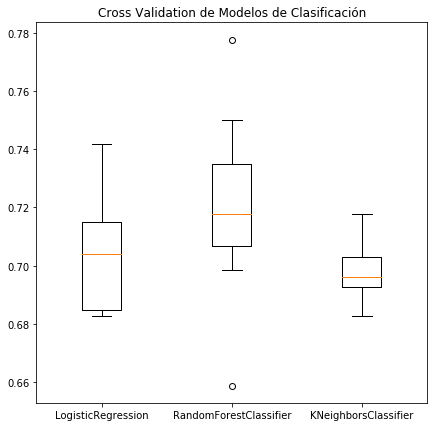

In [56]:
from sklearn.model_selection import cross_val_score

fig, ax = plt.subplots(figsize=(7,7))

cv_scores = {}
for name, model in models.items():
    cv_scores[name] = cross_val_score(model, X, y, cv=8, n_jobs=-1)
    print(f"Average CV score {name:22}: {cv_scores[name].mean()}")

ax.boxplot(cv_scores.values())
ax.set_title("Cross Validation de Modelos de Clasificación")
ax.set_xticklabels(cv_scores.keys())

plt.savefig("imgs/cv_models.png")
plt.show()

Como se aprecia en la imagen, el modelo `RandomForestClassifier` ahora es el de mayor _score_, puesto que antes se indicaba al `KNeighborsClassifier` como el mejor.

Sin embargo, `KNeighborsClassifier` presenta una menor distribución en su _score_. Esto podría indicar que está representando correctamente la data que se tiene.

Caso contrario sucede con `RandomForestClassifier`, ya que presenta una mayor distribución entre sus _scores_, e inclusive presenta _scores_ anómalos.

Para el modelo `LogisticRegression`, en este caso (aplicando CV), se mantiene en su misma pocisión, y presenta una distribución semenjante a la de `RandomForest`.

Una vez hemos observado los _scores_ obtenidos por los tres modelos, se procederá a medir cuán bien logran distinguir entre Riesgo Bueno y Riesgo Malo.

### 5.2. MATRIZ DE CONFUSIÓN

Se utiliza ahora otra métrica Matriz de confusión, y observar qué modelo realiza mejor clasificaciones para la clase `Bad Risk`, ya que se presentan menos registros clasificados con dicha clase en la data (solo 30% de la data es `Bad Risk`).

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred_knn    = knn.predict(X_test)
y_pred_rfc    = rfc.predict(X_test)
y_pred_logreg = logreg.predict(X_test)

In [93]:
def plot_confusion_matrix(cm, labels, title="Matriz de confusión"):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax = ax, square=True, cmap="RdYlGn", fmt='g'); # annot=True to annotate cells

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    return fig, ax

In [129]:
def plot_metrics_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(cm, ["Bad Risk", "Good Risk"], title=f"Matriz de confusión de {model_name}")
    
    plt.savefig(f"imgs/confusion_matrix_{model_name}.png")
    plt.show()

    print(f"Reporte de classificación de {model_name}".center(53,"="), end="\n\n")
    print(classification_report(y_test, y_pred, target_names=["Bad Risk","Good Risk"]))

#### 5.2.1. LOGISTIC REGRESSION

Por último, `LogisticRegression` presenta aproximadamente los aproximandamente mismos resultados que `KNeighbors`: logra clasificar correctamente a los `Good Risk`, pero no a los de `Bad Risk`.

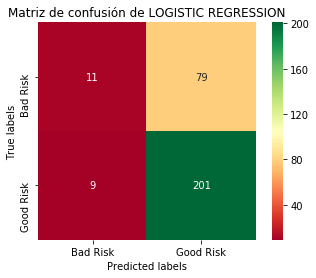

===Reporte de classificación de LOGISTIC REGRESSION==

              precision    recall  f1-score   support

    Bad Risk       0.55      0.12      0.20        90
   Good Risk       0.72      0.96      0.82       210

   micro avg       0.71      0.71      0.71       300
   macro avg       0.63      0.54      0.51       300
weighted avg       0.67      0.71      0.63       300



In [132]:
plot_metrics_confusion_matrix(y_test, y_pred_logreg, "LOGISTIC REGRESSION")

#### 5.2.2. RANDOM FOREST

Por otro lado, `RandomForest` presenta el mayor _recall_ de los tres modelos, aunque se sigue obteniendo un bajo indice de aciertos en clasificar a verdaderos `Bad Risk`.

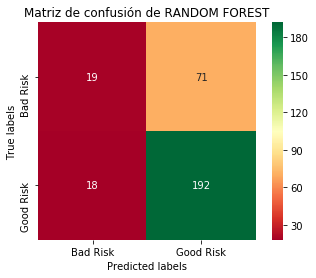

======Reporte de classificación de RANDOM FOREST=====

              precision    recall  f1-score   support

    Bad Risk       0.51      0.21      0.30        90
   Good Risk       0.73      0.91      0.81       210

   micro avg       0.70      0.70      0.70       300
   macro avg       0.62      0.56      0.56       300
weighted avg       0.67      0.70      0.66       300



In [131]:
plot_metrics_confusion_matrix(y_test, y_pred_rfc, "RANDOM FOREST")

#### 5.2.3. K-NEAREST NEIGHBORS

El modelo `KNeighbors` presenta un alto indice de aciertos en la clasificación de solicitantes a crédito que realmente poseen `Good Risk`. Sin embargo, no logra clasificar correctamente a los de `Bad Risk`.

Esto puede verse reflejado en el reporte de clasificación, en el que se señala que presenta una precisión aceptable, pero con un bajo _recall_ en clasificar `Bad Risk`. Es decir, `KNeighbors` no ha logrado acertar ni a la 5ta parte de los solicitantes que realmente presentan `Bad Risk`.

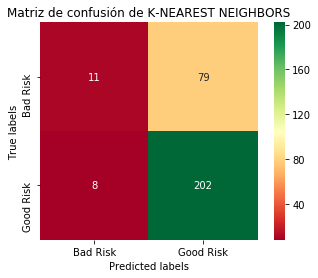

===Reporte de classificación de K-NEAREST NEIGHBORS==

              precision    recall  f1-score   support

    Bad Risk       0.58      0.12      0.20        90
   Good Risk       0.72      0.96      0.82       210

   micro avg       0.71      0.71      0.71       300
   macro avg       0.65      0.54      0.51       300
weighted avg       0.68      0.71      0.64       300



In [134]:
plot_metrics_confusion_matrix(y_test, y_pred_knn, "K-NEAREST NEIGHBORS")

### 5.3. CURVA ROC

In [110]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve_model(name_model, y_test, y_pred_prob, ax):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    ax.plot(fpr, tpr, label=name_model)
    return ax

In [125]:
def plot_roc_curve_all_models(models, X_test, y_test):
    fig, ax = plt.subplots(figsize=(10,10))
    
    for name, model in models.items():
        y_pred_prob_model = model.predict_proba(X_test)[:,1]
        
        plot_roc_curve_model(name, y_test, y_pred_prob_model, ax)
        auc_roc_model = roc_auc_score(y_test, y_pred_prob_model)
        print(f"AUC ROC {name:25}: {auc_roc_model}")
        
    ax.set_xlabel("Ratio Falso Positivo (FP)")
    ax.set_ylabel("Ratio Verdadero Positivo (TP)")
    ax.set_title("Curva ROC de modelos de clasificación")
    ax.legend(loc=4)
    
    return fig, ax

AUC ROC LogisticRegression       : 0.614021164021164
AUC ROC RandomForestClassifier   : 0.6295238095238095
AUC ROC KNeighborsClassifier     : 0.594920634920635


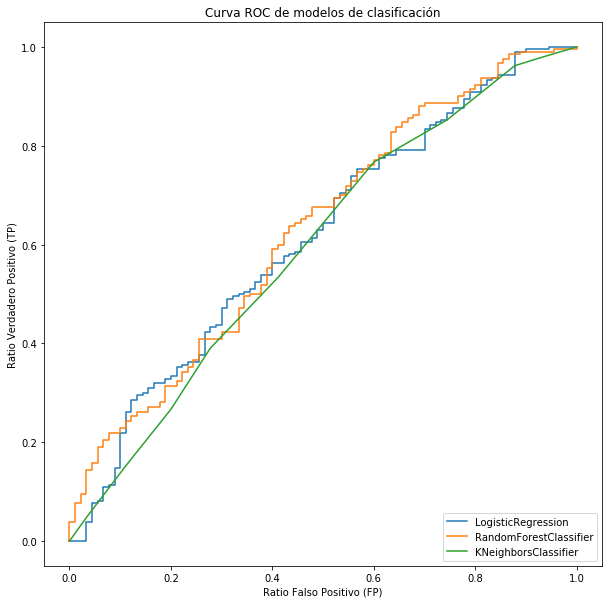

In [133]:
fig, ax = plot_roc_curve_all_models(models, X_test, y_test)

plt.savefig("imgs/roc_curve.png")
plt.show()

Comparando las AUC de cada modelo de clasificación, `RandomForest` es quien clasifica mejor a la data entregada, y `KNeighbors` es el modelo que menor lo realiza correctamente.

### 5.4. ATRIBUTOS MÁS INFLUYENTES

In [147]:
from sklearn.feature_selection import SelectFromModel

# fig, ax = plt.subplots(figsize=(10,10))
columns = clean_data.columns.values


#### 5.4.1. Logistic Regression

In [223]:
logreg.coef_.ravel()

array([ 2.96317152e-02,  5.48725439e-02,  3.13889326e-02,  3.08437642e-01,
       -5.41129973e-02,  7.76308499e-06, -3.65234777e-02,  1.14570969e-01])

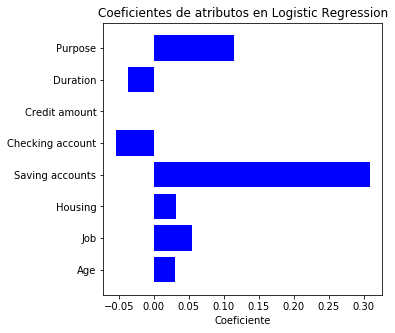

['Saving accounts', 'Purpose']

In [232]:
select_logreg = SelectFromModel(estimator=logreg, threshold=0.10)
select_logreg.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(5,5))
x_importance, y_importance = clean_data.drop("Risk", axis=1).columns, logreg.coef_.ravel()

ax.barh(x_importance, y_importance, color="blue")
ax.set_title("Coeficientes de atributos en Logistic Regression")
ax.set_xlabel("Coeficiente")

plt.savefig("imgs/logistic_regression_feature_importance.png")
plt.show()


[clean_data.columns[i] for i in select_logreg.get_support(indices=True)]

#### 5.4.2. Random Forest

Para el caso de `Random Forest`, este modelo otorga la facilidad de obtener los grados de importancia de cada atributo de la data con la que ha sido entrenado.

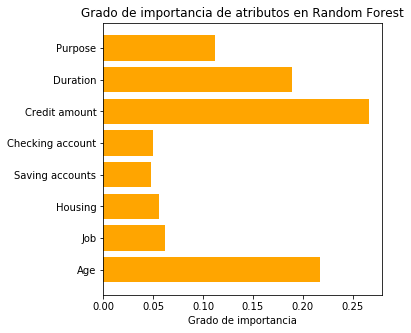

In [233]:
fig, ax = plt.subplots(figsize=(5,5))

x_importance, y_importance = clean_data.drop("Risk", axis=1).columns, rfc.feature_importances_

ax.barh(x_importance, y_importance, color="orange")
ax.set_title("Grado de importancia de atributos en Random Forest")
ax.set_xlabel("Grado de importancia")

plt.savefig("imgs/random_forest_feature_importance.png")
plt.show()

Y si aplicamos `SelectionFromModel`, se obtendrán que los atributos más influyentes son `Purpose`, `Duration`, `Credit amount` y `Age`.

In [212]:
select_rfc = SelectFromModel(estimator=rfc, threshold=0.10)
select_rfc.fit(X_train, y_train)

[clean_data.columns[i] for i in select_rfc.get_support(indices=True)]

['Age', 'Credit amount', 'Duration', 'Purpose']

#### 5.4.3. K-Nearest Neighbors

En caso de `KNeighbors`, no se puede determinar qué atributos son los más influyentes debido a que este modelo es un clasificador "perezoso", no construye el modelo explícitamente.

In [214]:
# select_knn = SelectFromModel(estimator=knn, threshold=0.10)
# select_knn.fit(X_train, y_train)

# [clean_data.columns[i] for i in select_knn.get_support(indices=True)]